In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Found 18713 files belonging to 7 classes.
Found 3217 files belonging to 7 classes.
Epoch 1/100
293/293 [==============================] - 595s 2s/step - loss: nan - accuracy: 0.1276 - val_loss: nan - val_accuracy: 0.1445
Epoch 2/100
293/293 [==============================] - 52s 176ms/step - loss: nan - accuracy: 0.1278 - val_loss: nan - val_accuracy: 0.1445
Epoch 3/100
293/293 [==============================] - 52s 175ms/step - loss: nan - accuracy: 0.1278 - val_loss: nan - val_accuracy: 0.1445
Epoch 4/100
293/293 [==============================] - 52s 176ms/step - loss: nan - accuracy: 0.1278 - val_loss: nan - val_accuracy: 0.1445
Epoch 5/100
293/293 [==============================] - 52s 176ms/step - loss: nan - accuracy: 0.1278 - val_loss: nan - val_accuracy: 0.1445
Epoch 6/100
293/293 [==============================] - 52s 176ms/step - loss: nan - accuracy: 0.1278 - val_loss: nan - val_accuracy: 0.1445
Epoch 7/100
293/293 [==============================] - 52s 176ms/step - loss: n

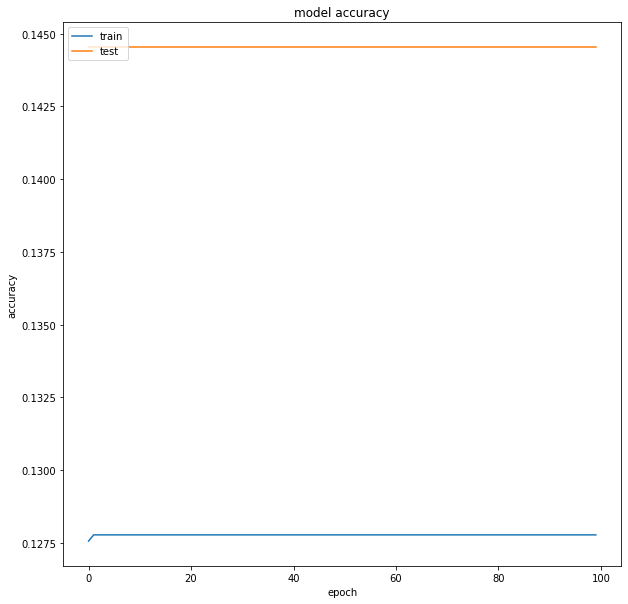

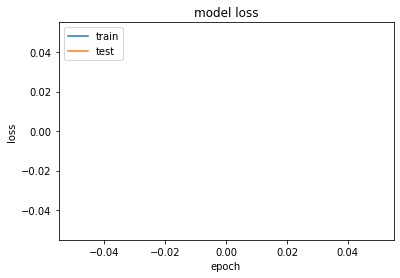


Total Training Time for the model:  1h 41m 56s


In [3]:
# Lab25- ResNet

import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import pathlib
from tensorflow import keras
from keras.layers import Input
from keras import Model
from google.colab import drive, files
import os


import time, datetime
start = datetime.datetime.now()
time.sleep(10)


# load

train_data_dir='/content/drive/MyDrive/Mura Datase_50%_Training Data_100%_Test data/MURA-v1.1/train'
test_data_dir = '/content/drive/MyDrive/Mura Datase_50%_Training Data_100%_Test data/MURA-v1.1/valid'


# data prep
batch_size = 64
img_height = 256
img_width = 256
trainX = tf.keras.utils.image_dataset_from_directory(train_data_dir, seed=123, image_size=(img_height, img_width), batch_size=batch_size)
testX = tf.keras.utils.image_dataset_from_directory(test_data_dir, seed=123, image_size=(img_height, img_width), batch_size=batch_size)
classes = trainX.class_names
plt.figure(figsize=(10, 10))

# model
def ResNet():
  input_layer = Input(shape=(256, 256, 3))
  res = keras.layers.ZeroPadding2D(padding=3, name='padding_conv1')(input_layer)
  res = keras.layers.Conv2D(64, (7, 7), strides=(2, 2), use_bias=False, name='conv1')(res)
  res = keras.layers.BatchNormalization(axis=3, epsilon=1e-5, name='bn_conv1')(res)
  res = keras.layers.Activation('relu', name='conv1_relu')(res)
  res = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='pool1')(res)
  res = conv_block(res, 3, [256, 256, 256], stage=2, block='a', strides=(1, 1))
  res = identity_block(res, 3, [64, 64, 256], stage=2, block='b')
  res = identity_block(res, 3, [64, 64, 256], stage=2, block='c')
  res = conv_block(res, 3, [128, 128, 512], stage=3, block='a')
  res = identity_block(res, 3, [128, 128, 512], stage=3, block='b')
  res = identity_block(res, 3, [128, 128, 512], stage=3, block='c')
  res = identity_block(res, 3, [128, 128, 512], stage=3, block='d')
  res = conv_block(res, 3, [256, 256, 1024], stage=4, block='a') #1
  res = identity_block(res, 3, [256, 256, 1024], stage=4, block='b')
  res = identity_block(res, 3, [256, 256, 1024], stage=4, block='c')
  res = identity_block(res, 3, [256, 256, 1024], stage=4, block='d')
  res = identity_block(res, 3, [256, 256, 1024], stage=4, block='e')
  res = identity_block(res, 3, [256, 256, 1024], stage=4, block='f')
  res = conv_block(res, 3, [512, 512, 2048], stage=5, block='a') #2
  res = identity_block(res, 3, [512, 512, 2048], stage=5, block='b')
  res = identity_block(res, 3, [512, 512, 2048], stage=5, block='c')
  res = keras.layers.GlobalAveragePooling2D(name='pool5')(res)
  res = keras.layers.Dense(4, activation='softmax', name='fc1000')(res)
  model = Model(input_layer, [res], name='ResNet')
  return model


def identity_block(input, kernel_size, filters, stage, block):
  filters1, filters2, filters3 = filters
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'
  IDconv = keras.layers.Conv2D(filters1, (1, 1), kernel_initializer='he_normal', name=conv_name_base + '2a')(input)
  IDbatch = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(IDconv)
  IDactive = keras.layers.Activation('relu')(IDbatch)
  IDconv = keras.layers.Conv2D(filters2, kernel_size, padding='same', kernel_initializer='he_normal', name=conv_name_base + '2b')(IDactive)
  IDbatch = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(IDconv)
  IDactive = keras.layers.Activation('relu')(IDbatch)
  IDconv = keras.layers.Conv2D(filters3, (1, 1), kernel_initializer='he_normal', name=conv_name_base + '2c')(IDactive)
  IDbatch = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(IDconv)
  IDlayer = keras.layers.add([IDbatch, input])
  identity = keras.layers.Activation('relu')(IDlayer)
  return identity

def conv_block(input, kernel_size, filters, stage, block, strides=(2, 2)):
  filters1, filters2, filters3 = filters
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'
  volconv = keras.layers.Conv2D(filters1, (1, 1), strides=strides, kernel_initializer='he_normal', name=conv_name_base + '2a')(input)
  volbatch = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(volconv)
  volactive = keras.layers.Activation('relu')(volbatch)
  volconv = keras.layers.Conv2D(filters2, kernel_size, padding='same', kernel_initializer='he_normal', name=conv_name_base + '2b')(volactive)
  volbatch = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(volconv)
  volactive = keras.layers.Activation('relu')(volbatch)
  volconv = keras.layers.Conv2D(filters3, (1, 1), kernel_initializer='he_normal', name=conv_name_base + '2c')(volactive)
  volbatch = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(volconv)
  shortcut = keras.layers.Conv2D(filters3, (1, 1), strides=strides, kernel_initializer='he_normal', name=conv_name_base + '1')(input)
  shortcutbatch = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '1')(shortcut)
  output = keras.layers.add([volbatch, shortcutbatch])
  convolution = keras.layers.Activation('relu')(output)
  return convolution

model = ResNet()
model.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
history = model.fit(trainX, validation_data=testX, epochs=100)

#y_vloss = history.history['val_loss']
#y_loss = history.history['loss']
#y_acc = history.history['accuracy']
#y_vacc = history.history['val_accuracy']

#fig, (ax1, ax2) = plt.subplots(1, 2)
#ax1.plot(np.arange(len(y_vloss)), y_vloss, marker='.', c='red')
#ax1.plot(np.arange(len(y_loss)), y_loss, marker='.', c='blue')
#ax1.grid()
#plt.setp(ax1, xlabel='epoch', ylabel='loss')

#ax2.plot(np.arange(len(y_vacc)), y_vacc, marker='.', c='red')
#ax2.plot(np.arange(len(y_acc)), y_acc, marker='.', c='blue')
#ax2.grid()
#plt.setp(ax2, xlabel='epoch', ylabel='accuracy')

#plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("./accuracy per epochs for SqueezeNet-graph.jpg")
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("./loss per epochs for SqueezeNet-graph.jpg")
plt.show()


#Training Time calculate
end = datetime.datetime.now()
diff = (end - start)
datetime.timedelta(seconds=10, microseconds=885206)

diff_seconds = int(diff.total_seconds())
minute_seconds, seconds = divmod(diff_seconds, 60)
hours, minutes = divmod(minute_seconds, 60)
hms = f"{hours}h {minutes}m {seconds}s"
print("\nTotal Training Time for the model: ", hms)